# **XAI4Spectra**

# **Loading data**

In [254]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import kennard_stone as ks

# loading a soil spectral dataset based on X-ray fluorescence (XRF)

data_complete = pd.read_csv('https://raw.githubusercontent.com/joseviniciusr/XAI4Spectra/refs/heads/main/XRFspectra.csv', sep=';') # Toledo 2022 dataset
data = data_complete.loc[:, '1':'15']
data.insert(0, 'exCa', data_complete['exCa'])  # inserting the target variable (e.g., exCa (exchangeable calcium))

## **PLS- (R or DA) modeling**

In [255]:
def vip_scores(pls_model):
    """
    Calculate VIP (Variable Importance in Projection) scores for a fitted PLS model.
    Parameters
    ----------
    - **pls_model** : fitted PLS model object from sklearn.cross_decomposition.PLSRegression
        The PLS model for which to calculate VIP scores.
    Returns
    -------
    - vip_scores : ndarray, shape (n_features,)
        VIP scores for each feature in the model.
    """
    import numpy as np

    t = pls_model.x_scores_ # X scores 
    w = pls_model.x_weights_ # X weights
    p = pls_model.y_loadings_ # Y loadings
    features, _ = w.shape # number of features
    vip = np.zeros(shape=(features,)) # initializing VIP scores array
    inner_sum = np.diag(t.T @ t @ p.T @ p) # inner sum calculation
    SS_total = np.sum(inner_sum) # total sum of squares
    vip = np.sqrt(features*(w**2 @ inner_sum)/ SS_total) # VIP calculation
    return pd.DataFrame(vip)

def explained_variance_from_scores(X, T, P, Q=None, Y=None):
    """
    Calculate percent variance explained (based on PCTVAR Matlab function) for X and Y
    by using the scores T and loadings P (and optionally Q for Y).
    Parameters
    ----------
    - **X** : array-like, shape (n_samples, n_features)
        X matrix used in PLS.
    - **T** : array-like, shape (n_samples, n_components)
        Scores matrix from PLS.
    - **P** : array-like, shape (n_features, n_components)
        Loadings matrix for X from PLS.
    - **Q** : array-like, shape (n_targets, n_components), optional
        Loadings matrix for Y from PLS. Required if Yc is provided.
    - **Y** : array-like, shape (n_samples, n_targets), optional
       Y matrix used in PLS.
    Returns
    -------
    - result : dict with keys:
        - **'varX_cumulative'** : ndarray shape (n_components,)
            Percent cumulative variance of X explained by 1..j components.
        - **'varX_per_component'** : ndarray shape (n_components,)
            Percent variance of X explained per component.
        - **'varY_cumulative'** : ndarray shape (n_components,), or None
            Percent cumulative variance of Y explained by 1..j components (if Yc and Q provided).
        - **'varY_per_component'** : ndarray shape (n_components,), or None
            Percent variance of Y explained per component (if Yc and Q provided).
    """
    import numpy as np
    X = np.asarray(X, dtype=float) # X preprocessed data
    T = np.asarray(T, dtype=float) # scores
    P = np.asarray(P, dtype=float) # loadings for X

    n_comp = T.shape[1]
    TSS_X = np.sum(X ** 2) # total sum of squares of X
    if TSS_X == 0: # avoid division by zero
        raise ValueError("TSS_X == 0 (X does not have variability).")

    pctvarX_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for X

    for j in range(1, n_comp + 1): # loop over components
        Xhat_j = T[:, :j] @ P[:, :j].T # reconstructed X using j components
        SS_Xhat_j = np.sum(Xhat_j ** 2) # sum of squares of reconstructed X
        pctvarX_cum[j-1] = 100.0 * SS_Xhat_j / TSS_X # percent variance explained cumulativa
    
    # incremental (per component)
    pctvarX_per = np.empty_like(pctvarX_cum) # incremental percent variance for X
    pctvarX_per[0] = pctvarX_cum[0] # first component
    pctvarX_per[1:] = pctvarX_cum[1:] - pctvarX_cum[:-1] # rest

    # Y (if provided)
    pctvarY_cum = None # cumulative percent variance for Y
    pctvarY_per = None # incremental percent variance for Y
    if Q is not None and Y is not None: # if Y loadings and Y centered provided
        Q = np.asarray(Q, dtype=float) # loadings for Y
        Y = np.asarray(Y, dtype=float) # centered (and possibly scaled) Y
        TSS_Y = np.sum(Y ** 2) # total sum of squares of Y
        if TSS_Y == 0: # avoid division by zero
            pctvarY_cum = np.zeros(n_comp, dtype=float) # all zeros if Y has no variance
            pctvarY_per = np.zeros(n_comp, dtype=float) # all zeros
        else:
            pctvarY_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for Y
            for j in range(1, n_comp + 1): # loop over components
                Yhat_j = T[:, :j] @ Q[:, :j].T # reconstructed Y using j components
                SS_Yhat_j = np.sum(Yhat_j ** 2) # sum of squares of reconstructed Y
                pctvarY_cum[j-1] = 100.0 * SS_Yhat_j / TSS_Y # percent variance explained cumulativa
            pctvarY_per = np.empty_like(pctvarY_cum) # incremental percent variance for Y
            pctvarY_per[0] = pctvarY_cum[0] # first component
            pctvarY_per[1:] = pctvarY_cum[1:] - pctvarY_cum[:-1] # rest

        return {
            'varX_cumulative': pctvarX_cum[-1],
            'varX_per_component': pctvarX_per[-1],
            'varY_cumulative': pctvarY_cum[-1],
            'varY_per_component': pctvarY_per[-1]
            }         


def pls_optimized(Xcal, ycal, LVmax, Xpred=None, ypred=None, aim='regression', cv=10):
    """
    ## PLS optimized
    Function to fit a PLS regression or PLS-DA model with optimization of latent variables (LVs)
    using cross-validation. It calculates various performance metrics for calibration, cross-validation,
    and prediction (if provided) datasets
    **Parameters**:
    - **Xcal** : pd.DataFrame
        Calibration dataset features.
    - **ycal** : pd.Series or np.ndarray
        Calibration dataset target variable (regression) or binary class labels (classification).
    - **LVmax** : int
        Maximum number of latent variables to consider.
    - **Xpred** : pd.DataFrame, optional
        Prediction dataset features. Default is None.
    - **ypred** : pd.Series or np.ndarray, optional
        Prediction dataset target variable (regression) or binary class labels (classification). Default is None.
    - **aim** : str, optional
        Type of analysis: 'regression' for PLS regression or 'classification' for PLS-DA. Default is 'regression'.
    - **cv** : int, optional
        Number of cross-validation folds. Default is 10
        
    **Returns**:
    - **df_results** : pd.DataFrame
        DataFrame containing performance metrics for each number of latent variables.
    - **calres** : pd.DataFrame
        DataFrame containing predicted values for the calibration dataset.
    - **predres** : pd.DataFrame
        DataFrame containing predicted values for the prediction dataset (if provided).
    """

    import numpy as np
    import pandas as pd

    if aim == 'regression': # regression (PLSR)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import mean_squared_error, r2_score
        from scipy.stats import iqr

        results = [] # list to store results for each LV
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsr = PLSRegression(n_components=n_comp, scale=False)
            plsr.fit(Xcal, ycal)
            y_cal = plsr.predict(Xcal).flatten()
            calres[f'LV_{n_comp}'] = y_cal

            y_cv = cross_val_predict(plsr, Xcal, ycal, cv=cv) # cross-validated predictions
            y_cv = np.array(y_cv).flatten()

            R2_cal = r2_score(ycal, y_cal) # determination coefficient
            r2_cal = np.corrcoef(ycal, y_cal)[0, 1] ** 2 # correlation coefficient squared
            rmse_cal = np.sqrt(mean_squared_error(ycal, y_cal))
            R2_cv = r2_score(ycal, y_cv)
            r2_cv = np.corrcoef(ycal, y_cv)[0, 1] ** 2
            rmsecv = np.sqrt(mean_squared_error(ycal, y_cv))
            rpd_cv = ycal.std() / rmsecv if rmsecv != 0 else np.nan
            rpiq_cv = iqr(ycal, rng=(25, 75)) / rmsecv if rmsecv != 0 else np.nan
            bias_cv = np.sum(ycal - y_cv) / ycal.shape[0]
            SDV_cv = (ycal - y_cv) - bias_cv
            SDV_cv = np.sqrt(np.sum(SDV_cv * SDV_cv) / (ycal.shape[0] - 1)) if ycal.shape[0] > 1 else np.nan
            tbias_cv = abs(bias_cv) * (np.sqrt(ycal.shape[0]) / SDV_cv) if SDV_cv not in (0, np.nan) else np.nan
            
            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsr.x_scores_, plsr.x_loadings_,
                                               Q=plsr.y_loadings_, Y=ycal) # explained variance
            
            # vip scores
            vip = vip_scores(plsr).T
            vip.columns = plsr.feature_names_in_ # setting feature names

            if Xpred is not None and ypred is not None: # prediction set
                y_pred = plsr.predict(Xpred).flatten()
                predres[f'LV_{n_comp}'] = y_pred

                R2_pred = r2_score(ypred, y_pred) # determination coefficient
                r2_pred = np.corrcoef(ypred, y_pred)[0, 1] ** 2 # correlation coefficient squared
                rmsep = np.sqrt(mean_squared_error(ypred, y_pred))
                rpd_pred = ypred.std() / rmsep if rmsep != 0 else np.nan
                rpiq_pred = iqr(ypred, rng=(25, 75)) / rmsep if rmsep != 0 else np.nan
                bias_pred = np.sum(ypred - y_pred) / ypred.shape[0]
                SDV_pred = (ypred - y_pred) - bias_pred
                SDV_pred = np.sqrt(np.sum(SDV_pred * SDV_pred) / (ypred.shape[0] - 1)) if ypred.shape[0] > 1 else np.nan
                tbias_pred = abs(bias_pred) * (np.sqrt(ypred.shape[0]) / SDV_pred) if SDV_pred not in (0, np.nan) else np.nan
            else:
                r2_pred = rmsep = rpd_pred = rpiq_pred = bias_pred = tbias_pred = None

            results.append({
                'LVs': n_comp,
                'R2_Cal': R2_cal,
                'r2_Cal': r2_cal,
                'RMSEC': rmse_cal,
                'R2_CV': R2_cv,
                'r2_Cv': r2_cv,
                'RMSECV': rmsecv,
                'RPD_CV': rpd_cv,
                'RPIQ_CV': rpiq_cv,
                'Bias_CV': bias_cv,
                'tbias_CV': tbias_cv,
                'R2_Pred': R2_pred,
                'r2_Pred': r2_pred,
                'RMSEP': rmsep,
                'RPD_Pred': rpd_pred,
                'RPIQ_Pred': rpiq_pred,
                'Bias_Pred': bias_pred,
                'tbias_Pred': tbias_pred,
                'X_Cum_Exp_Var' : exp_var['varX_cumulative'],
                'Y_Cum_Exp_Var' : exp_var['varY_cumulative'],
                'X_Ind_Exp_Var' : exp_var['varX_per_component'],
                'Y_Ind_Exp_Var' : exp_var['varY_per_component']
            })

        model = plsr  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    elif aim == 'classification': # classification (PLS-DA)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import accuracy_score, confusion_matrix

        results = []
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        # ensure binary classes
        ycal_series = pd.Series(ycal).reset_index(drop=True) # ensure it's a Series
        unique_labels = ycal_series.unique() # unique class labels
        if len(unique_labels) != 2: # check for binary classification
            raise ValueError(f"PLS-DA (this function) expects 2 classes (binary). Found: {unique_labels}")

        label_to_num = {lab: idx for idx, lab in enumerate(unique_labels)} # mapping labels to 0 and 1
        num_to_label = {idx: lab for lab, idx in label_to_num.items()} # reverse mapping for predictions
       
        # prepare ycal numeric
        ycal_numeric = np.array([label_to_num[i] for i in ycal]) 

        # prepare ypred numeric if provided
        ypred_numeric = None
        if ypred is not None:
            ypred_numeric = np.array([label_to_num[i] for i in ypred])

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsda = PLSRegression(n_components=n_comp, scale=False)
            plsda.fit(Xcal, ycal_numeric)

            # calibration continuous predictions -> binarize
            y_cal_cont = plsda.predict(Xcal).flatten()
            y_cal_bin = (y_cal_cont >= 0.5).astype(int)
            y_cal_class = np.array([num_to_label[i] for i in y_cal_bin])
            calres[f'LV_{n_comp}'] = y_cal_class

            # cross-validated continuous predictions -> binarize
            y_cv_cont = cross_val_predict(plsda, Xcal, ycal_numeric, cv=cv)
            y_cv_cont = np.array(y_cv_cont).flatten()
            y_cv_bin = (y_cv_cont >= 0.5).astype(int)

            # metrics
            acc_cal = accuracy_score(ycal_numeric, y_cal_bin)
            cm_cal = confusion_matrix(ycal_numeric, y_cal_bin)
            # safe unpack for binary confusion matrix
            if cm_cal.size == 4:
                tn, fp, fn, tp = cm_cal.ravel()
            else:
                tn = fp = fn = tp = np.nan
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

            acc_cv = accuracy_score(ycal_numeric, y_cv_bin)
            cm_cv = confusion_matrix(ycal_numeric, y_cv_bin)
            if cm_cv.size == 4:
                tn_cv, fp_cv, fn_cv, tp_cv = cm_cv.ravel()
            else:
                tn_cv = fp_cv = fn_cv = tp_cv = np.nan
            sensitivity_cv = tp_cv / (tp_cv + fn_cv) if (tp_cv + fn_cv) > 0 else np.nan
            specificity_cv = tn_cv / (tn_cv + fp_cv) if (tn_cv + fp_cv) > 0 else np.nan

            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsda.x_scores_, plsda.x_loadings_,
                                               Q=plsda.y_loadings_, Y=ycal_numeric.reshape(-1, 1)) # explained variance

            # vip scores
            vip = vip_scores(plsda).T
            vip.columns = plsda.feature_names_in_ # setting feature names

            # prediction set (if provided)
            if Xpred is not None and ypred is not None:
                y_pred_cont = plsda.predict(Xpred).flatten()
                y_pred_bin = (y_pred_cont >= 0.5).astype(int)
                y_pred_class = np.array([num_to_label[i] for i in y_pred_bin])
                predres[f'LV_{n_comp}'] = y_pred_class

                acc_pred = accuracy_score(ypred_numeric, y_pred_bin)
                cm_pred = confusion_matrix(ypred_numeric, y_pred_bin)
                if cm_pred.size == 4:
                    tn_p, fp_p, fn_p, tp_p = cm_pred.ravel()
                else:
                    tn_p = fp_p = fn_p = tp_p = np.nan
                sensitivity_p = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else np.nan
                specificity_p = tn_p / (tn_p + fp_p) if (tn_p + fp_p) > 0 else np.nan
            else:
                acc_pred = sensitivity_p = specificity_p = cm_pred = tn_p = fp_p = fn_p = tp_p = None

            results.append({
                'LVs': n_comp,
                'Accuracy Cal': acc_cal,
                'Sensitivity Cal': sensitivity,
                'Specificity Cal': specificity,
                'CM Cal': cm_cal,
                'Accuracy CV': acc_cv,
                'Sensitivity CV': sensitivity_cv,
                'Specificity CV': specificity_cv,
                'CM CV': cm_cv,
                'Accuracy Pred': acc_pred,
                'Sensitivity Pred': sensitivity_p,
                'Specificity Pred': specificity_p,
                'CM Pred': cm_pred,
                'X Cum Exp Var' : exp_var['varX_cumulative'],
                'Y Cum Exp Var' : exp_var['varY_cumulative'],
                'X Ind Exp Var' : exp_var['varX_per_component'],
                'Y Ind Exp Var' : exp_var['varY_per_component']
            })

        model = plsda  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    else:
        raise ValueError("Parameter `aim` must be 'regression' or 'classification'.")

    return df_results, calres, predres, model, vip

In [256]:
def extract_spectral_zones(Xcal, cuts):
    """
    Extract spectral zones from a DataFrame based on specified cuts.
    
    Parameters
    ----------
    - **Xcal** : pd.DataFrame
        DataFrame with spectral data, where columns are wavelengths/energies.
    - **cuts** : list of tuples/lists or dicts
        Each item defines a spectral zone to extract.
        - If tuple/list: (start, end) or (name, start, end)
        - If dict: {'name': str, 'start': float, 'end': float}
    
    Returns
    -------
    - **zones** : dict
        Dictionary where keys are zone names and values are DataFrames with the extracted spectral zones.
    """
    import numpy as np
    import pandas as pd

    # convert the column names to numeric when possible (NaN when not convertible)
    col_nums = pd.to_numeric(Xcal.columns.astype(str), errors='coerce')
    zones = {} # dictionary to store extracted zones

    for cut in cuts:
        # normalize cut format
        if isinstance(cut, dict): # if dict
            name = cut.get('name', f"{cut.get('start')}-{cut.get('end')}") # default name if not provided
            start = cut.get('start') # getting start value
            end = cut.get('end') # getting end value
        elif isinstance(cut, (list, tuple)): # if list/tuple
            if len(cut) == 2: 
                start, end = cut # getting start and end values
                name = f"{start}-{end}" # default name
            elif len(cut) == 3: # if name provided
                name, start, end = cut # getting name, start and end values
            else:
                raise ValueError("Cuts in tuple/list format must have 2 or 3 elements.")
        else:
            raise ValueError("Each cut must be a dict or a tuple/list.")

        # validate start and end
        try:
            s = float(start)
            e = float(end)
        except Exception: # Exception for conversion errors
            raise ValueError("star and end must be numeric values (int/float or convertible strings).")

        if s > e: # swap if necessary
            s, e = e, s

        # to select columns whose numeric value is in the interval [s, e]
        mask = (~np.isnan(col_nums)) & (col_nums >= s) & (col_nums <= e)
        selected_cols = list(Xcal.columns[mask])

        # piecing the zone DataFrame into the dictionary
        zones[name] = Xcal.loc[:, selected_cols]

    return zones

# **Regression case**

In [257]:
# splitting the data into calibration and prediction sets by kennard-stone algorithm
datacal_reg, datapred_reg = ks.train_test_split(data, test_size=0.25)
Xcalreg = datacal_reg.iloc[:, 1:].reset_index(drop=True)
ycalreg = datacal_reg.iloc[:, 0].reset_index(drop=True)
Xpredreg = datapred_reg.iloc[:, 1:].reset_index(drop=True)
ypredreg = datapred_reg.iloc[:, 0].reset_index(drop=True)

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-04 11:50:43,307 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-04 11:50:43,312 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [258]:
# preprocessings
import preprocessings as prepr # preprocessing methods for XRF data

Xcalreg_prep, mean_calreg, mean_calreg_poisson  = prepr.poisson(Xcalreg, mc=True)
Xpredreg_prep = ((Xpredreg/np.sqrt(mean_calreg)) - mean_calreg_poisson)

In [259]:
plsr_results = pls_optimized(Xcalreg_prep, ycalreg, 
                             LVmax=5, 
                             Xpred=Xpredreg_prep,
                             ypred=ypredreg,
                             aim='regression',
                             cv=10)
plsr_results[0]

LVs    R2_Cal    r2_Cal     RMSEC     R2_CV     r2_Cv    RMSECV    RPD_CV  \
0    1  0.656883  0.656883  1.051658  0.622770  0.623123  1.102696  1.633304   
1    2  0.736333  0.736333  0.921893  0.651480  0.664269  1.059904  1.699246   
2    3  0.745287  0.745287  0.906106  0.634746  0.658008  1.085052  1.659864   
3    4  0.769532  0.769532  0.861903  0.625823  0.661211  1.098225  1.639954   
4    5  0.781251  0.781251  0.839704  0.629997  0.667999  1.092083  1.649177   

    RPIQ_CV   Bias_CV  ...   r2_Pred     RMSEP  RPD_Pred  RPIQ_Pred  \
0  2.217293 -0.002055  ...  0.450342  1.150487  1.257410   1.721011   
1  2.306812 -0.005960  ...  0.728276  0.880903  1.642216   2.247694   
2  2.253349 -0.012925  ...  0.794095  0.797528  1.813896   2.482671   
3  2.226319 -0.035702  ...  0.823721  0.755711  1.914269   2.620051   
4  2.238841 -0.037054  ...  0.791529  0.782207  1.849425   2.531299   

   Bias_Pred  tbias_Pred  X_Cum_Exp_Var  Y_Cum_Exp_Var  X_Ind_Exp_Var  \
0  -0.436808    2.959459      22.692968      11.941667      22.692968   
1  -0.334291    2.957763      43.587589      13.386025      20.894621   
2  -0.255070    2.434145      71.133516      13.548790      27.545927   
3  -0.302328    3.147724      80.643752      13.989554       9.510235   
4  -0.302154    3.019937      90.924579      14.202595      10.280828   

   Y_Ind_Exp_Var  
0      11.941667  
1       1.444358  
2       0.162765  
3       0.440764  
4       0.213041  

[5 rows x 22 columns]

In [260]:
plsr_results[4].T.plot() # VIP scores plot

In [261]:
pd.options.plotting.backend = 'plotly' # setting plotly as the backend for pandas plotting 
Xcalreg.T.plot() # easily plotting the spectra 

In [262]:
# establishing spectral cuts based on expert knowledge of XRF spectra
spectral_cuts = [
('Al', 1.38, 1.60),
('Si', 1.64, 1.84),
('P', 1.94, 2.10),
('S', 2.20, 2.44),
('Rh L + Ar', 2.56, 3.10),
('K', 3.22, 3.42),
('Ca ka', 3.58, 3.82),
('Ca kb', 3.92, 4.14),
('Ti ka', 4.38, 4.66),
('Ti kb', 4.82, 5.06),
('Mn', 5.78, 6.02),
('Fe ka', 6.26, 6.56),
('Fe kb', 6.92, 7.22),
('Cu', 7.92, 8.20)
]

spectral_zones_reg = extract_spectral_zones(Xcalreg, spectral_cuts) # extracting the spectral zones
spectral_zones_reg['Ca ka'].T.plot(title='spectral zone') # plotting the Al ka spectral zone

In [263]:
vip_scores_zones = extract_spectral_zones(plsr_results[4], spectral_cuts) # extracting VIP scores for the spectral zones
vip_scores_zones['Ca ka'].T.plot(title='VIP scores for Ca ka zone') # plotting the VIP scores for all spectral zone

In [264]:
plsr_spectral_zone_results = {} # dictionary to store the results for each spectral zone
for zone_name, Xcalreg_zone in spectral_zones_reg.items():
    # preparing the corresponding Xpred zone
    col_zone = Xcalreg_zone.columns # getting the columns of the spectral zone
    Xpredreg_zone = Xpredreg.loc[:, col_zone] # selecting the same columns in Xpredreg

    # preprocessing
    Xcalreg_zone_prep, mean_calreg_zone, mean_calreg_poisson_zone  = prepr.poisson(Xcalreg_zone, mc=True)
    Xpredreg_zone_prep = ((Xpredreg_zone/np.sqrt(mean_calreg_zone)) - mean_calreg_poisson_zone)

    # PLSR with optimized latent variables for the spectral zone
    plsr_zone_result = pls_optimized(Xcalreg_zone_prep, 
                                      ycalreg,
                                      LVmax=5,
                                      Xpred=Xpredreg_zone_prep,
                                      ypred=ypredreg,
                                      aim='regression',
                                      cv=10)
    plsr_spectral_zone_results[zone_name] = plsr_zone_result # storing only the results DataFrame

r2_pred_list = []
for zone_name, results_df in plsr_spectral_zone_results.items():
    r2_pred = results_df[0].iloc[-1]['r2_Pred'] # get R2 Pred for the last row (highest LV)
    r2_pred_list.append({'Spectral Zone': zone_name, 'r2_Pred': r2_pred}) # joining the results
r2_pred_df = pd.DataFrame(r2_pred_list)
r2_pred_df.plot(kind='line', x='Spectral Zone', y='r2_Pred', title='r2 Pred by Spectral Zone')    

In [265]:
Y_cum_var_list = [] # list to store Y Cum Var for each zone
for zone_name, results_df in plsr_spectral_zone_results.items(): # iterating over the spectral zones
    y_cum_var = results_df[0].iloc[-1]['Y_Cum_Exp_Var']    # get Y Cum Exp Var for the last row (highest LV)
    Y_cum_var_list.append({'Spectral Zone': zone_name, 'Y_Cum_Exp_Var': y_cum_var}) # appending to the list
Y_cum_var_df = pd.DataFrame(Y_cum_var_list)
Y_cum_var_df.plot(kind='line', x='Spectral Zone', y='Y_Cum_Exp_Var', title='Y Cum Exp Var by Spectral Zone') # plotting the results

# **Classification case**

In [266]:
# Creating a new column 'Class' based on the condition of 'BSP' values
data_complete['Class'] = np.where(data_complete['BSP'] > 50.00, 'eut', 'dist') # eutrophic (eut) if BSP > 50.00 (higher fertility), otherwise dystrophic (dist)
data_eut = data_complete[data_complete['Class'] == 'eut'].reset_index(drop=True)
data_dist = data_complete[data_complete['Class'] == 'dist'].reset_index(drop=True)

In [267]:
# splitting the data into calibration and prediction sets by kennard-stone algorithm
Xeut_cal, Xeut_pred = ks.train_test_split(data_eut.loc[:, '1':'15'], test_size=0.30) # class eutrophic
Xeut_cal = Xeut_cal.reset_index(drop=True)
Xeut_pred = Xeut_pred.reset_index(drop=True)

Xdist_cal, Xdist_pred = ks.train_test_split(data_dist.loc[:, '1':'15'], test_size=0.30) # class dystrophic
Xdist_cal = Xdist_cal.reset_index(drop=True)
Xdist_pred = Xdist_pred.reset_index(drop=True)

Xcalclass = pd.concat([Xeut_cal, Xdist_cal], axis=0).reset_index(drop=True) # concatenating both classes
Xpredclass = pd.concat([Xeut_pred, Xdist_pred], axis=0).reset_index(drop=True)
ycalclass = pd.Series(['eut']*Xeut_cal.shape[0] + ['dist']*Xdist_cal.shape[0]) # creating the target variable for calibration set
ypredclass = pd.Series(['eut']*Xeut_pred.shape[0] + ['dist']*Xdist_pred.shape[0]) # creating the target variable for prediction set

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-04 11:50:48,991 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

2025-11-04 11:50:48,994 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 

In [268]:
# preprocessings
import preprocessings as prepr # preprocessing methods for XRF data

Xcalclass_prep, mean_calclass, mean_calclass_poisson  = prepr.poisson(Xcalclass, mc=True)
Xpredclass_prep = ((Xpredclass/np.sqrt(mean_calclass)) - mean_calclass_poisson)

In [269]:
# performing PLS-DA with optimized latent variables
plsda_results = pls_optimized(Xcalclass_prep, 
                              ycalclass,
                              LVmax=4,
                              Xpred=Xpredclass_prep,
                              ypred=ypredclass,
                              aim='classification',
                              cv=10)
plsda_results[0]

LVs  Accuracy Cal  Sensitivity Cal  Specificity Cal                CM Cal  \
0    1      0.804054         0.845070         0.766234  [[59, 18], [11, 60]]   
1    2      0.851351         0.915493         0.792208   [[61, 16], [6, 65]]   
2    3      0.831081         0.901408         0.766234   [[59, 18], [7, 64]]   
3    4      0.871622         0.887324         0.857143   [[66, 11], [8, 63]]   

   Accuracy CV  Sensitivity CV  Specificity CV                 CM CV  \
0     0.722973        0.746479        0.701299  [[54, 23], [18, 53]]   
1     0.810811        0.873239        0.753247   [[58, 19], [9, 62]]   
2     0.797297        0.845070        0.753247  [[58, 19], [11, 60]]   
3     0.770270        0.845070        0.701299  [[54, 23], [11, 60]]   

   Accuracy Pred  Sensitivity Pred  Specificity Pred              CM Pred  \
0       0.750000          0.870968          0.636364  [[21, 12], [4, 27]]   
1       0.843750          0.967742          0.727273   [[24, 9], [1, 30]]   
2       0.828125          0.967742          0.696970  [[23, 10], [1, 30]]   
3       0.875000          0.967742          0.787879   [[26, 7], [1, 30]]   

   X Cum Exp Var  Y Cum Exp Var  X Ind Exp Var  Y Ind Exp Var  
0      24.084452      18.486320      24.084452      18.486320  
1      46.025807      20.883518      21.941354       2.397198  
2      70.291459      21.960174      24.265653       1.076656  
3      78.655943      24.395837       8.364483       2.435663

In [270]:
# vip scores plot for PLS-DA
plsda_results[4].T.plot() # VIP scores plot

In [271]:
# Xcal_prep.to_csv('Xcal_prep_calss.csv', index=False, sep=';')
# Xpred_prep.to_csv('Xpred_prep_class.csv', index=False, sep=';')
# ycal.to_csv('ycal_class.csv', index=False, sep=';')
# ypred.to_csv('ypred_class.csv', index=False, sep=';')

In [272]:
spectral_zones_class = extract_spectral_zones(Xcalclass, spectral_cuts) # extracting the spectral zones
spectral_zones_class['Ca ka'].T.plot(title='spectral zone') # plotting the Al ka spectral zone

In [273]:
# spectral zones VIP scores for PLS-DA
vip_scores_zones_class = extract_spectral_zones(plsda_results[4], spectral_cuts) # extracting VIP scores for the spectral zones
vip_scores_zones_class['Ca ka'].T.plot(title='VIP scores for Ca ka zone') # plotting the VIP scores for all spectral zone

In [274]:
plsda_spectral_zone_results = {}
for zone_name, Xcalclass_zone in spectral_zones_class.items():
    # preparing the corresponding Xpred zone
    col_zone = Xcalclass_zone.columns # getting the columns of the zone
    Xpred_zone = Xpredclass.loc[:, col_zone] # selecting the columns from Xpredclass

    # preprocessing
    Xcalclass_zone_prep, mean_calclass_zone, mean_calclass_poisson_zone  = prepr.poisson(Xcalclass_zone, mc=True)
    Xpredclass_zone_prep = ((Xpred_zone/np.sqrt(mean_calclass_zone)) - mean_calclass_poisson_zone)

    # PLS-DA with optimized latent variables for the spectral zone
    plsda_zone_result = pls_optimized(Xcalclass_zone_prep, 
                                      ycalclass,
                                      LVmax=1,
                                      Xpred=Xpredclass_zone_prep,
                                      ypred=ypredclass,
                                      aim='classification',
                                      cv=10)
    plsda_spectral_zone_results[zone_name] = plsda_zone_result # storing only the results DataFrame

accuracy_pred_list = [] # list to store Accuracy Pred for each zone
for zone_name, results_df in plsda_spectral_zone_results.items(): # iterating over the spectral zones
    accuracy_pred = results_df[0].iloc[-1]['Accuracy Pred']    # get Accuracy Pred for the last row (highest LV)
    accuracy_pred_list.append({'Spectral Zone': zone_name, 'Accuracy Pred': accuracy_pred}) # appending to the list
accuracy_pred_df = pd.DataFrame(accuracy_pred_list)
accuracy_pred_df.plot(kind='line', x='Spectral Zone', y='Accuracy Pred', title='Accuracy Pred by Spectral Zone') # plotting the results

In [275]:
Y_cum_var_list = [] # list to store Y Cum Var for each zone
for zone_name, results_df in plsda_spectral_zone_results.items(): # iterating over the spectral zones
    y_cum_var = results_df[0].iloc[-1]['Y Cum Exp Var']    # get Y Cum Exp Var for the last row (highest LV)
    Y_cum_var_list.append({'Spectral Zone': zone_name, 'Y Cum Exp Var': y_cum_var}) # appending to the list
Y_cum_var_df = pd.DataFrame(Y_cum_var_list)
Y_cum_var_df.plot(kind='line', x='Spectral Zone', y='Y Cum Exp Var', title='Y Cum Exp Var by Spectral Zone') # plotting the results

# **Extracting predicates - plsda case**

In [276]:
# calculating the median for each spectral zone DataFram with respect to the variables (columns)
zone_sums_df = pd.DataFrame({
    zone: df.sum(axis=1) for zone, df in spectral_zones_class.items()
})
zone_sums_df

Al  Rh L + Ar       K   Ca ka   Ca kb     Fe ka    Fe kb
0    26.450    149.635  17.040  34.065  14.435  4138.760  646.345
1    30.875    153.020  18.040  36.785  14.955  3933.505  613.505
2    28.245    151.535  13.980  25.385  13.315  4155.890  646.610
3    29.555    152.310  13.790  30.950  14.345  4319.450  674.640
4    31.980    154.015  15.965  22.100  12.750  4153.135  647.395
..      ...        ...     ...     ...     ...       ...      ...
143  32.140    149.690  13.920  20.360  13.100  4558.835  705.485
144  30.330    151.950  15.140  23.580  13.410  4261.720  664.520
145  32.130    153.370  14.160  13.630  12.220  4341.810  672.910
146  27.650    145.455  13.730  17.670  11.440  3856.690  605.545
147  36.620    148.300  13.780  20.120  13.140  4696.610  730.030

[148 rows x 7 columns]

In [277]:
zone_vip_sums_df = pd.DataFrame({
    zone: df.sum(axis=1) for zone, df in vip_scores_zones_class.items()
})
zone_vip_sums_df

Al  Rh L + Ar         K      Ca ka      Ca kb      Fe ka    Fe kb
0  7.271224   5.500865  6.967078  56.658765  11.688802  55.542629  21.1671

In [278]:
# calculating the quantiles for each column of zone_sums_df
zone_quantiles = zone_sums_df.quantile([0.25, 0.5, 0.75])
zone_quantiles

Al  Rh L + Ar        K   Ca ka     Ca kb       Fe ka     Fe kb
0.25  30.67625  148.77125  13.7675  17.840  12.24625  4121.11125  645.0875
0.50  32.18500  150.54500  14.6450  22.105  12.91000  4251.20000  662.7825
0.75  33.85250  152.74625  15.8175  29.580  14.15250  4340.48375  675.6100

In [279]:
# extraindo predicados baseados nos quartis (incluindo o 50%)
zone_predicate_list = []
predicate_num = 1
for zone in zone_sums_df.columns:
    q25 = zone_quantiles.loc[0.25, zone]
    q50 = zone_quantiles.loc[0.50, zone]
    q75 = zone_quantiles.loc[0.75, zone]

    # low
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} <= {q25:.2f}",
        'zone': zone,
        'thresholds': f"{q25:.2f}",
        'operator': "<="
    })
    predicate_num += 1
    # low-medium
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} > {q25:.2f} and {zone} <= {q50:.2f}",
        'zone': zone,
        'thresholds': f"{q25:.2f},{q50:.2f}",
        'operator': "> and <="
    })
    predicate_num += 1
    # medium-high
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} > {q50:.2f} and {zone} <= {q75:.2f}",
        'zone': zone,
        'thresholds': f"{q50:.2f},{q75:.2f}",
        'operator': "> and <="
    })
    predicate_num += 1
    # high
    zone_predicate_list.append({
        'predicate': f'P{predicate_num}',
        'rule': f"{zone} > {q75:.2f}",
        'zone': zone,
        'thresholds': f"{q75:.2f}",
        'operator': ">"
    })
    predicate_num += 1

predicates_df = pd.DataFrame(zone_predicate_list)
predicates_df

predicate                                        rule       zone  \
0         P1                                 Al <= 30.68         Al   
1         P2                  Al > 30.68 and Al <= 32.19         Al   
2         P3                  Al > 32.19 and Al <= 33.85         Al   
3         P4                                  Al > 33.85         Al   
4         P5                         Rh L + Ar <= 148.77  Rh L + Ar   
5         P6  Rh L + Ar > 148.77 and Rh L + Ar <= 150.55  Rh L + Ar   
6         P7  Rh L + Ar > 150.55 and Rh L + Ar <= 152.75  Rh L + Ar   
7         P8                          Rh L + Ar > 152.75  Rh L + Ar   
8         P9                                  K <= 13.77          K   
9        P10                    K > 13.77 and K <= 14.64          K   
10       P11                    K > 14.64 and K <= 15.82          K   
11       P12                                   K > 15.82          K   
12       P13                              Ca ka <= 17.84      Ca ka   
13       P14            Ca ka > 17.84 and Ca ka <= 22.10      Ca ka   
14       P15            Ca ka > 22.10 and Ca ka <= 29.58      Ca ka   
15       P16                               Ca ka > 29.58      Ca ka   
16       P17                              Ca kb <= 12.25      Ca kb   
17       P18            Ca kb > 12.25 and Ca kb <= 12.91      Ca kb   
18       P19            Ca kb > 12.91 and Ca kb <= 14.15      Ca kb   
19       P20                               Ca kb > 14.15      Ca kb   
20       P21                            Fe ka <= 4121.11      Fe ka   
21       P22        Fe ka > 4121.11 and Fe ka <= 4251.20      Fe ka   
22       P23        Fe ka > 4251.20 and Fe ka <= 4340.48      Fe ka   
23       P24                             Fe ka > 4340.48      Fe ka   
24       P25                             Fe kb <= 645.09      Fe kb   
25       P26          Fe kb > 645.09 and Fe kb <= 662.78      Fe kb   
26       P27          Fe kb > 662.78 and Fe kb <= 675.61      Fe kb   
27       P28                              Fe kb > 675.61      Fe kb   

         thresholds  operator  
0             30.68        <=  
1       30.68,32.19  > and <=  
2       32.19,33.85  > and <=  
3             33.85         >  
4            148.77        <=  
5     148.77,150.55  > and <=  
6     150.55,152.75  > and <=  
7            152.75         >  
8             13.77        <=  
9       13.77,14.64  > and <=  
10      14.64,15.82  > and <=  
11            15.82         >  
12            17.84        <=  
13      17.84,22.10  > and <=  
14      22.10,29.58  > and <=  
15            29.58         >  
16            12.25        <=  
17      12.25,12.91  > and <=  
18      12.91,14.15  > and <=  
19            14.15         >  
20          4121.11        <=  
21  4121.11,4251.20  > and <=  
22  4251.20,4340.48  > and <=  
23          4340.48         >  
24           645.09        <=  
25    645.09,662.78  > and <=  
26    662.78,675.61  > and <=  
27           675.61         >

In [280]:
# function to evaluate a predicate for a given value
def eval_predicate(value, thresholds, operator): # evaluates a predicate for a given value
    if operator == "<=": # less than or equal
        return float(value <= float(thresholds)) # returns 1.0 if true, 0.0 if false
    elif operator == ">": # greater than
        return float(value > float(thresholds)) # returns 1.0 if true, 0.0 if false
    elif operator == "> and <=": # between two thresholds
        t1, t2 = map(float, thresholds.split(",")) # splitting thresholds
        return float((value > t1) and (value <= t2)) # returns 1.0 if true, 0.0 if false
    else:
        return np.nan  # unknown operator

# generating the predicate indicator DataFrame
predicate_indicator_df = pd.DataFrame(index=zone_sums_df.index) # initializing empty DataFrame

for _, row in predicates_df.iterrows(): # iterating over each predicate (iterrows returns index and row)
    pred = row['predicate'] # getting predicate name
    zone = row['zone'] # getting zone name
    thresholds = row['thresholds'] # getting thresholds
    operator = row['operator'] # getting operator
    predicate_indicator_df[pred] = zone_sums_df[zone].apply(lambda v: eval_predicate(v, thresholds, operator)).astype(int)
predicate_indicator_df # displaying the predicate indicator DataFrame

P1  P2  P3  P4  P5  P6  P7  P8  P9  P10  ...  P19  P20  P21  P22  P23  \
0     1   0   0   0   0   1   0   0   0    0  ...    0    1    0    1    0   
1     0   1   0   0   0   0   0   1   0    0  ...    0    1    1    0    0   
2     1   0   0   0   0   0   1   0   0    1  ...    1    0    0    1    0   
3     1   0   0   0   0   0   1   0   0    1  ...    0    1    0    0    1   
4     0   1   0   0   0   0   0   1   0    0  ...    0    0    0    1    0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
143   0   1   0   0   0   1   0   0   0    1  ...    1    0    0    0    0   
144   1   0   0   0   0   0   1   0   0    0  ...    1    0    0    0    1   
145   0   1   0   0   0   0   0   1   0    1  ...    0    0    0    0    0   
146   1   0   0   0   1   0   0   0   1    0  ...    0    0    1    0    0   
147   0   0   0   1   1   0   0   0   0    1  ...    1    0    0    0    0   

     P24  P25  P26  P27  P28  
0      0    0    1    0    0  
1      0    1    0    0    0  
2      0    0    1    0    0  
3      0    0    0    1    0  
4      0    0    1    0    0  
..   ...  ...  ...  ...  ...  
143    1    0    0    0    1  
144    0    0    0    1    0  
145    1    0    0    1    0  
146    0    1    0    0    0  
147    1    0    0    0    1  

[148 rows x 28 columns]

In [281]:
# co-ocurrence matrix
co_occurrence_matrix = np.dot(predicate_indicator_df.T, predicate_indicator_df)
co_occurrence_matrix_df = pd.DataFrame(co_occurrence_matrix, index=predicate_indicator_df.columns, columns=predicate_indicator_df.columns)

## the co-occurrence matrix indicates how many samples satisfy each pair of predicates
## for example, if P1 and P2 co-occur in 10 samples, the value at (P1, P2) and (P2, P1) will be 10
## the principal diagonal indicates how many samples satisfy each individual predicate
## while the off-diagonal elements indicate co-occurrence counts

In [282]:
# plotting the co-occurrence matrix via heatmap to visualize relationships between predicates
co_occurrence_matrix_df.plot(kind='imshow', title='Co-Occurrence Matrix of Predicates', color_continuous_scale='Viridis')

In [283]:
# inserting the assigned class based on the model predictions to the predicate indicator DataFrame
predicate_indicator_df.insert(0, 'Class_predicted', plsda_results[1].iloc[:, -1]) # inserting the predicted class from plsda_results
predicate_indicator_df

Class_predicted  P1  P2  P3  P4  P5  P6  P7  P8  P9  ...  P19  P20  P21  \
0               eut   1   0   0   0   0   1   0   0   0  ...    0    1    0   
1               eut   0   1   0   0   0   0   0   1   0  ...    0    1    1   
2               eut   1   0   0   0   0   0   1   0   0  ...    1    0    0   
3               eut   1   0   0   0   0   0   1   0   0  ...    0    1    0   
4               eut   0   1   0   0   0   0   0   1   0  ...    0    0    0   
..              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...   
143             eut   0   1   0   0   0   1   0   0   0  ...    1    0    0   
144            dist   1   0   0   0   0   0   1   0   0  ...    1    0    0   
145            dist   0   1   0   0   0   0   0   1   0  ...    0    0    0   
146            dist   1   0   0   0   1   0   0   0   1  ...    0    0    1   
147            dist   0   0   0   1   1   0   0   0   0  ...    1    0    0   

     P22  P23  P24  P25  P26  P27  P28  
0      1    0    0    0    1    0    0  
1      0    0    0    1    0    0    0  
2      1    0    0    0    1    0    0  
3      0    1    0    0    0    1    0  
4      1    0    0    0    1    0    0  
..   ...  ...  ...  ...  ...  ...  ...  
143    0    0    1    0    0    0    1  
144    0    1    0    0    0    1    0  
145    0    0    1    0    0    1    0  
146    0    0    0    1    0    0    0  
147    0    0    1    0    0    0    1  

[148 rows x 29 columns]


Resumo do Grafo:
- Total de nós: 30
- Total de arestas: 376
- Nós de predicados: 28
- Nós de classes: 2


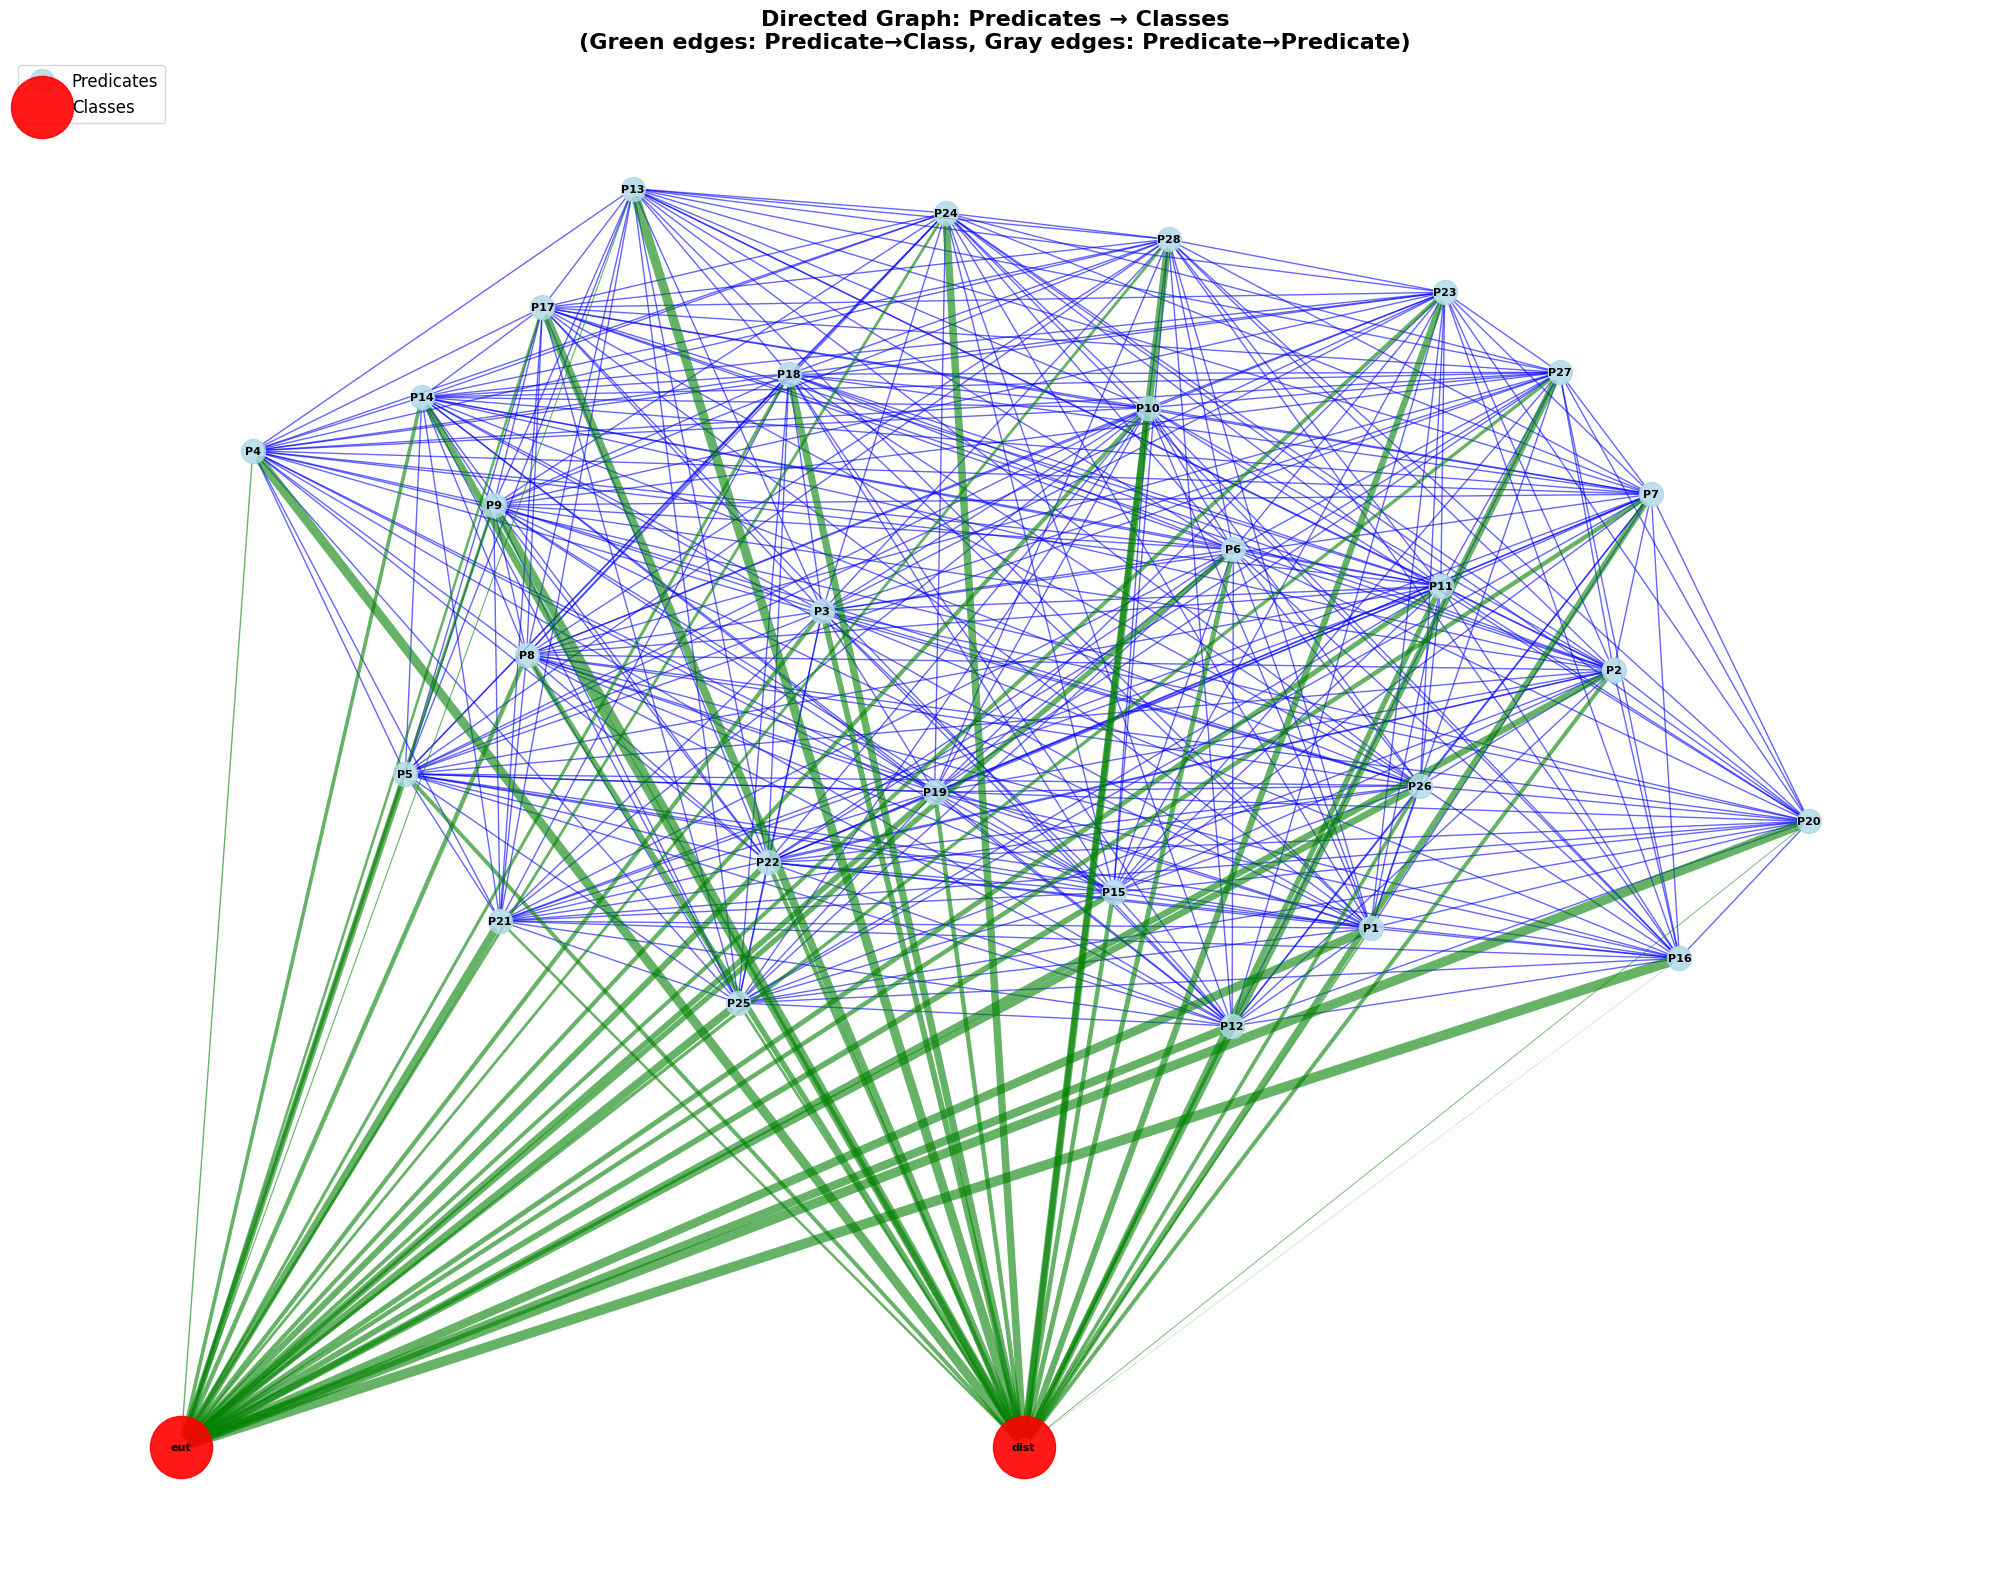

- Green edges show paths from predicates to classes (thickness = number of samples)
- Gray edges show conditional relationships between predicates


In [284]:
import networkx as nx

# Creating an empty graph
G = nx.Graph()

# Adding nodes and edges based on predicates and classes
# Getting predicates from the predicate indicator DataFrame (columns except 'Class_predicted')
predicados = list(predicate_indicator_df.columns[1:])
for predicado in predicados:
    G.add_node(predicado, node_type='predicate')  # Adding each predicate as a node with attribute

# Passo 2: Adicionar nós das classes
# Obtém as classes únicas da coluna 'Class_predicted'
classes = predicate_indicator_df['Class_predicted'].unique()
for classe in classes:
    G.add_node(classe, node_type='class')  # Adiciona cada classe como um nó com atributo

# Passo 3: Adicionar arestas entre predicados (Predicado → Predicado)
# Peso da aresta = quantidade de amostras que satisfazem ambos os predicados
contador_arestas_pred = 0
for i, pred_i in enumerate(predicados): # iterando sobre os predicados
    for pred_j in predicados[i+1:]:  # Evita duplicatas e auto-loops usando i+1
        # Obtém o valor da matriz de co-ocorrência para os dois predicados
        peso = co_occurrence_matrix_df.loc[pred_i, pred_j] # peso da aresta
        
        # Adiciona aresta apenas se houver pelo menos uma amostra em comum
        if peso > 0:
            G.add_edge(pred_i, pred_j, weight=peso, edge_type='pred-pred')
            contador_arestas_pred += 1

# Passo 4: Adicionar arestas entre predicados e classes (Predicado → Classe)
# Peso da aresta = quantidade de amostras que satisfazem o predicado E foram classificadas naquela classe
contador_arestas_classe = 0
for predicado in predicados: # iterando sobre os predicados
    for classe in classes: # iterando sobre as classes
        # Conta quantas amostras satisfazem o predicado (valor = 1) E foram classificadas na classe
        peso = predicate_indicator_df[ # peso da aresta
            (predicate_indicator_df[predicado] == 1) & # satisfaz o predicado
            (predicate_indicator_df['Class_predicted'] == classe) # e pertence à classe
        ].shape[0]
        
        # Adiciona aresta apenas se houver pelo menos uma amostra
        if peso > 0:
            G.add_edge(predicado, classe, weight=peso, edge_type='pred-class')
            contador_arestas_classe += 1

# Resumo do grafo
print(f"\nResumo do Grafo:")
print(f"- Total de nós: {G.number_of_nodes()}")
print(f"- Total de arestas: {G.number_of_edges()}")
print(f"- Nós de predicados: {len(predicados)}")
print(f"- Nós de classes: {len(classes)}")

import matplotlib.pyplot as plt 


fig, ax = plt.subplots(figsize=(20, 16)) # criando a figura e o eixo

predicate_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'predicate'] # lista de nós de predicados
class_nodes = [n for n in G.nodes() if G.nodes[n]['node_type'] == 'class'] # lista de nós de classes

pos = nx.spring_layout(G, k=2, iterations=50, seed=42) # layout de primavera para melhor espaçamento 
# o k é um parâmetro que afeta a distância entre os nós
# quanto maior o k, maior a distância entre os nós
# o iterations é o número de iterações para o algoritmo de layout

min_y = min([pos[n][1] for n in pos]) # encontrar a posição y mínima para ajustar os nós de classe
# Ajustar posições dos nós de classe para ficarem alinhados na parte inferior
for i, classe in enumerate(class_nodes): # iterando sobre os nós de classe
    pos[classe] = (i - len(class_nodes)/2, min_y - 1)  # posicionando na parte inferior

# o draw_networkx_nodes e draw_networkx_edges desenham os nós e arestas do grafo
nx.draw_networkx_nodes(G, pos, 
                       nodelist=predicate_nodes,
                       node_color='lightblue',
                       node_size=300,
                       alpha=0.8,
                       label='Predicates')
nx.draw_networkx_nodes(G, pos,
                       nodelist=class_nodes,
                       node_color='red',
                       node_size=2000,
                       alpha=0.9,
                       label='Classes')

# o draw_networkx_edges desenha as arestas do grafo
# Predicate → Predicate edges (gray, thinner)
pred_pred_edges = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'pred-pred'] # selecionando as arestas de predicado para predicado
nx.draw_networkx_edges(G, pos,
                       edgelist=pred_pred_edges,
                       edge_color='blue',
                       alpha=0.6,
                       #width=0.5,
                       arrows=True,
                       arrowsize=10)

# Predicate → Class edges (green, thicker, weighted by count)
pred_class_edges = [(u, v) for u, v, d in G.edges(data=True) if d['edge_type'] == 'pred-class']
edge_weights = [G[u][v]['weight']/5 for u, v in pred_class_edges]  # Scale for visualization
nx.draw_networkx_edges(G, pos,
                       edgelist=pred_class_edges,
                       edge_color='green',
                       alpha=0.6,
                       width=edge_weights,
                       arrows=True,
                       arrowsize=15)

# o draw_networkx_labels desenha os rótulos dos nós
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# adicionando título e legenda
plt.title('Directed Graph: Predicates → Classes\n(Green edges: Predicate→Class, Gray edges: Predicate→Predicate)', 
          fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"- Green edges show paths from predicates to classes (thickness = number of samples)")
print(f"- Gray edges show conditional relationships between predicates")

#  **Directed Graph based on VIP scores**

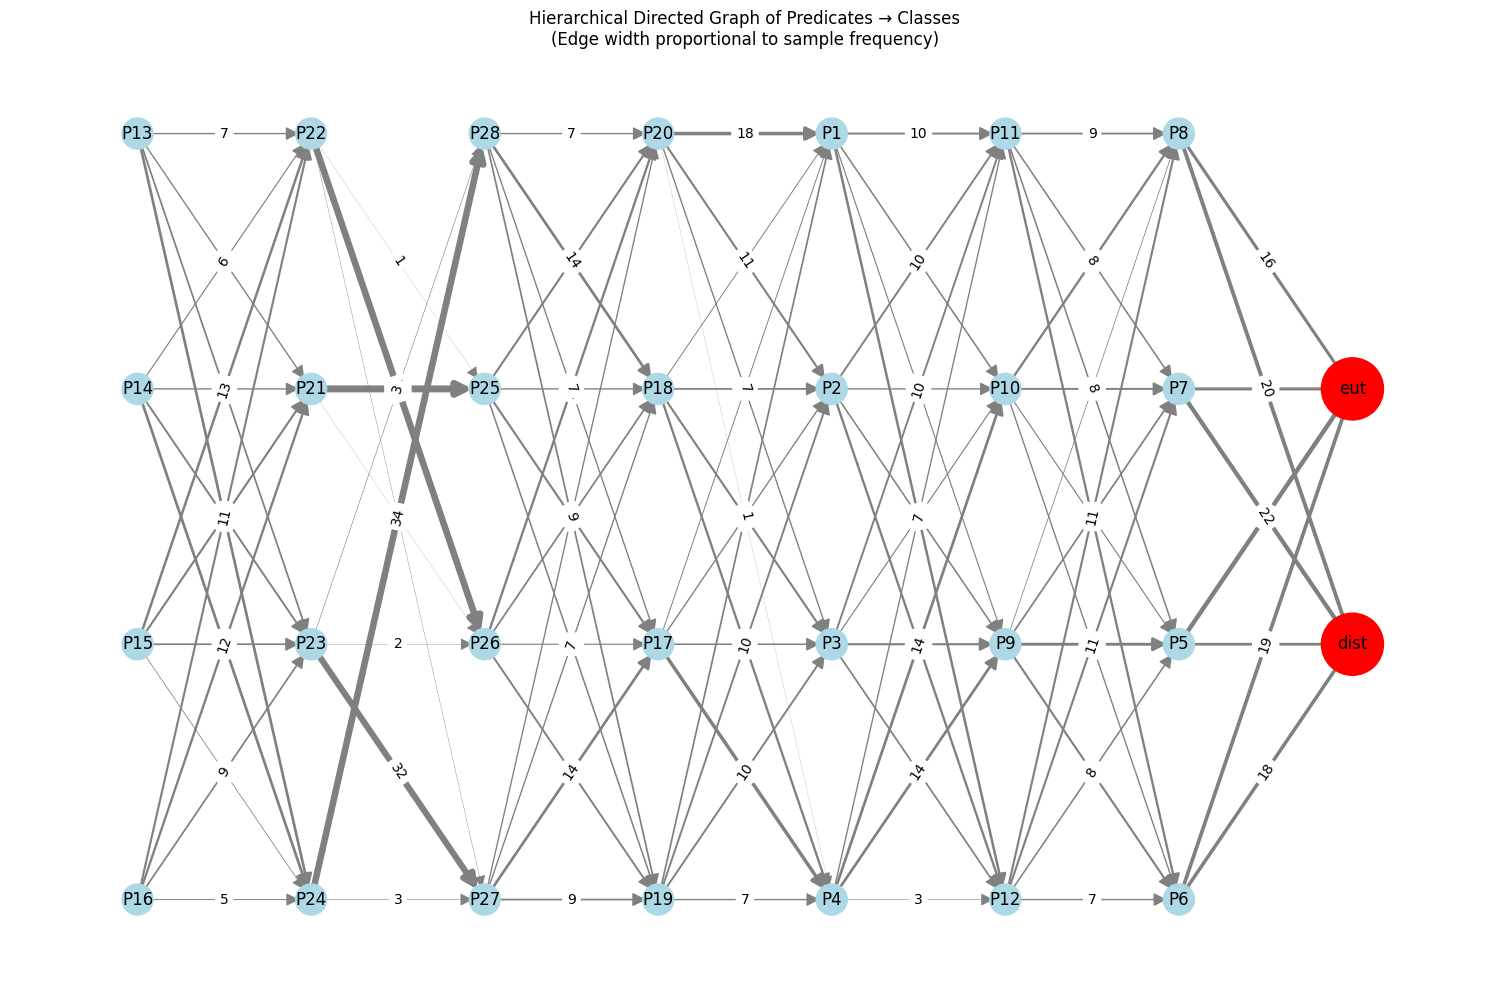


Métricas do Grafo:
Número de nós: 30
Número de arestas: 98
Densidade do grafo: 0.113

Caminhos mais frequentes:

Para classe eut:
- P13 → P21 → P25 → P20 → P1 → P12 → P6 → eut
- P13 → P21 → P25 → P20 → P1 → P12 → P8 → eut
- P13 → P21 → P25 → P20 → P1 → P12 → P7 → eut

Para classe dist:
- P13 → P21 → P25 → P20 → P1 → P12 → P6 → dist
- P13 → P21 → P25 → P20 → P1 → P12 → P8 → dist
- P13 → P21 → P25 → P20 → P1 → P12 → P7 → dist


In [285]:
# 1. Criar hierarquia baseada em VIP scores
def create_predicate_hierarchy(zone_vip_sums_df, predicates_df):
    # Ordenar zonas por VIP score acumulado
    zone_order = zone_vip_sums_df.mean().sort_values(ascending=False).index
    
    # Criar dicionário de níveis para cada predicado
    predicate_levels = {}
    current_level = 0
    
    for zone in zone_order:
        # Pegar predicados desta zona
        zone_predicates = predicates_df[predicates_df['zone'] == zone]['predicate'].tolist()
        for pred in zone_predicates:
            predicate_levels[pred] = current_level
        current_level += 1
    
    return predicate_levels

# 2. Criar grafo direcionado
DG = nx.DiGraph()

# 3. Adicionar nós com atributos de nível
predicate_levels = create_predicate_hierarchy(zone_vip_sums_df, predicates_df)
for pred, level in predicate_levels.items():
    DG.add_node(pred, level=level, type='predicate')

# 4. Adicionar nós de classe com nível máximo + 1
classes = predicate_indicator_df['Class_predicted'].unique()
max_level = max(predicate_levels.values())
for cls in classes:
    DG.add_node(cls, level=max_level + 1, type='class')

# 5. Criar arestas baseadas em caminhos de amostras
for idx in predicate_indicator_df.index:
    # Obter predicados ativos para esta amostra
    active_preds = predicate_indicator_df.iloc[idx, 1:][predicate_indicator_df.iloc[idx, 1:] == 1].index.tolist()
    sample_class = predicate_indicator_df.iloc[idx, 0]
    
    # Ordenar predicados por nível
    active_preds.sort(key=lambda x: predicate_levels[x])
    
    # Criar arestas entre predicados consecutivos
    for i in range(len(active_preds)-1):
        pred1, pred2 = active_preds[i], active_preds[i+1]
        if predicate_levels[pred1] <= predicate_levels[pred2]:  # Manter DAG
            if DG.has_edge(pred1, pred2):
                DG[pred1][pred2]['weight'] += 1
            else:
                DG.add_edge(pred1, pred2, weight=1)
    
    # Conectar último predicado à classe
    if active_preds:
        last_pred = active_preds[-1]
        if DG.has_edge(last_pred, sample_class):
            DG[last_pred][sample_class]['weight'] += 1
        else:
            DG.add_edge(last_pred, sample_class, weight=1)

# 6. Visualização
plt.figure(figsize=(15, 10))

# Posicionamento por níveis
pos = nx.multipartite_layout(DG, subset_key='level', align='vertical')

# Desenhar nós
nx.draw_networkx_nodes(DG, pos, 
                      node_color=['red' if d['type']=='class' else 'lightblue' 
                                for n, d in DG.nodes(data=True)],
                      node_size=[2000 if d['type']=='class' else 500 
                               for n, d in DG.nodes(data=True)])



# Desenhar arestas com espessura proporcional ao peso
edges = DG.edges(data=True)
weights = [d['weight'] for _, _, d in edges]
nx.draw_networkx_edges(DG, pos, width=[w/max(weights)*5 for w in weights],
                      edge_color='gray', arrows=True, arrowsize=20)

# Adicionar rótulos de peso nas arestas
edge_labels = {(u, v): d['weight'] for u, v, d in DG.edges(data=True)}
nx.draw_networkx_edge_labels(DG, pos, edge_labels, font_size=10)

# Adicionar rótulos
nx.draw_networkx_labels(DG, pos)

plt.title("Hierarchical Directed Graph of Predicates → Classes\n(Edge width proportional to sample frequency)")
plt.axis('off')
plt.tight_layout()
plt.show()

# 7. Análise de métricas do grafo
print("\nMétricas do Grafo:")
print(f"Número de nós: {DG.number_of_nodes()}")
print(f"Número de arestas: {DG.number_of_edges()}")
print(f"Densidade do grafo: {nx.density(DG):.3f}")
print("\nCaminhos mais frequentes:")
for cls in classes:
    paths = list(nx.all_simple_paths(DG, source=list(DG.nodes())[0], target=cls))
    if paths:
        print(f"\nPara classe {cls}:")
        for path in paths[:3]:  # Top 3 caminhos
            print(f"- {' → '.join(path)}")

In [286]:
# Calculate local reaching centrality for all nodes
local_centrality = {node: nx.local_reaching_centrality(DG, node) for node in DG.nodes()}
pd.DataFrame.from_dict(local_centrality, orient='index', columns=['Local Reaching Centrality']).sort_values(by='Local Reaching Centrality', ascending=False)

Local Reaching Centrality
P13                    0.896552
P14                    0.896552
P15                    0.896552
P16                    0.896552
P22                    0.724138
P23                    0.724138
P21                    0.689655
P24                    0.689655
P25                    0.620690
P26                    0.620690
P27                    0.620690
P28                    0.620690
P17                    0.482759
P18                    0.482759
P19                    0.482759
P20                    0.482759
P1                     0.344828
P2                     0.344828
P3                     0.344828
P4                     0.344828
P9                     0.206897
P10                    0.206897
P11                    0.206897
P12                    0.206897
P5                     0.068966
P6                     0.068966
P7                     0.068966
P8                     0.068966
eut                    0.000000
dist                   0.000000

In [287]:
# Calculating betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(DG)
pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Betweenness Centrality']).sort_values(by='Betweenness Centrality', ascending=False)

Betweenness Centrality
P27                 0.052463
P26                 0.052463
P18                 0.051724
P17                 0.051724
P20                 0.051724
P19                 0.051724
P2                  0.049261
P1                  0.049261
P4                  0.049261
P3                  0.049261
P10                 0.036946
P9                  0.036946
P12                 0.036946
P11                 0.036946
P25                 0.036207
P28                 0.036207
P22                 0.032348
P23                 0.032348
P24                 0.021839
P21                 0.021839
P5                  0.014778
P6                  0.014778
P7                  0.014778
P8                  0.014778
P16                 0.000000
P15                 0.000000
P14                 0.000000
P13                 0.000000
eut                 0.000000
dist                0.000000